In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Jun 11 17:18:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
print("sklearn version: ", sklearn.__version__)
assert sklearn.__version__ >= "0.20"

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
print("TF version: ", tf.__version__)
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# GPU test
print("GPU installed: ",tf.test.is_built_with_gpu_support())

# To prevent "CUDNN_STATUS_ALLOC_FAILED" error with GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
    
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

sklearn version:  1.0.2
TF version:  2.8.2
GPU installed:  True
1 Physical GPUs, 1 Logical GPUs


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
byclass_train = pd.read_csv("/content/drive/MyDrive/emnist-byclass-train.csv")
byclass_test = pd.read_csv("/content/drive/MyDrive/emnist-byclass-test.csv")

mapp = pd.read_csv("/content/drive/MyDrive/emnist-byclass-mapping.txt", delimiter = ' ', index_col=0, header=None, squeeze=True)

In [6]:
print("Train: %s, Test: %s, Map: %s" %(byclass_train.shape, byclass_test.shape, mapp.shape))

Train: (697931, 785), Test: (116322, 785), Map: (62,)


# DATA Processing

In [7]:
# label만 뽑아내기
y_train = byclass_train[['35']]

# data만 뽑아내기
X_train = byclass_train.drop(['35'], axis=1)

# test에 대해서 반복
y_test = byclass_test[['18']]
x_test = byclass_test.drop(['18'], axis=1)

In [8]:
print(X_train.shape,y_train.shape,x_test.shape,y_test.shape)

(697931, 784) (697931,) (116322, 784) (116322,)


In [9]:
# Normalise data and reshape
X_train = np.array(X_train) / 255.0
y_train = np.array(y_train)
x_test = np.array(x_test) / 255.0
y_test = np.array(y_test)


In [10]:
X_train.astype('float32')
x_test.astype('float32')

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [11]:
#Reshaping all images into 28*28 for pre-processing
X_train = X_train.reshape(X_train.shape[0], 28, 28)
x_test = x_test.reshape(x_test.shape[0], 28, 28)
print(X_train.shape,x_test.shape)

(697931, 28, 28) (116322, 28, 28)


In [12]:
def image(data):
        image = np.fliplr(data)
        image = np.rot90(image)
        return image

def create_images(data, start, end):
    images = []
    for i in range(start,end):
        images.append(image(data[i]))
    return images

In [13]:
#one-hot encoding
number_of_classes = 62

y_train = tf.keras.utils.to_categorical(y_train, number_of_classes)
y_test = tf.keras.utils.to_categorical(y_test, number_of_classes)

In [14]:
# Reshape image for CNN 4D
X_train = X_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)
print("X_train_oo: ", X_train.shape)

X_train_oo:  (697931, 28, 28, 1)


In [15]:
# Partition to train and val
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state = 42)

# Application of VGG-5 

In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import callbacks

In [17]:
from keras.layers import BatchNormalization, Dropout, Activation, Conv2D, MaxPooling2D, Flatten
tf.random.set_seed(42)
np.random.seed(42)

model2 = Sequential()

model2.add(Conv2D(40, (3, 3), input_shape=(28, 28, 1), padding='same', kernel_initializer='he_normal'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Conv2D(40, (3, 3), padding='same', kernel_initializer='he_normal'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size = (2,2), strides =(2,2)))

model2.add(Conv2D(80, (3, 3), padding='same', kernel_initializer='he_normal'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Conv2D(80, (3, 3), padding='same', kernel_initializer='he_normal'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size = (2,2), strides =(2,2)))

#3
model2.add(Conv2D(160, (3, 3), padding='same', kernel_initializer='he_normal'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Conv2D(160, (3, 3), padding='same', kernel_initializer='he_normal'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size = (2,2), strides =(2,2)))

model2.add(Conv2D(320, (3, 3), padding='same', kernel_initializer='he_normal'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Conv2D(320, (3, 3), padding='same', kernel_initializer='he_normal'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Conv2D(320, (3, 3), padding='same', kernel_initializer='he_normal'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size = (2,2), strides =(2,2)))

model2.add(Flatten())
model2.add(Dropout(.3))

model2.add(Dense(640, activation='relu', kernel_initializer='he_normal'))
model2.add(Dense(320, activation='relu', kernel_initializer='he_normal'))
model2.add(Dense(units = 62, activation='softmax'))

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 40)        400       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 40)       160       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 28, 28, 40)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 40)        14440     
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 40)       160       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 28, 28, 40)        0

In [ ]:
adam = keras.optimizers.Adam(learning_rate=1e-3, decay=1e-4)
model2.compile(adam, 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Set callback functions to stop training early and save the best model so far
keras_callbacks   = [
    callbacks.EarlyStopping(monitor = 'val_accuracy', patience =5,
                            mode = 'auto', verbose = 1),
    callbacks.ModelCheckpoint(filepath = 'best_model_cnn_emnist.h5', monitor = 'val_loss',
                              save_best_only = True, mode = 'auto', verbose = 1)
]

In [ ]:
model_history2 = model2.fit(X_train, y_train,
                    epochs = 20,
                    batch_size = 64,
                    verbose = 1,                    
                    validation_data=(X_valid, y_valid),
                    callbacks=keras_callbacks)


Epoch 1/20
8725/8725 [==============================] - ETA: 0s - loss: 0.5868 - accuracy: 0.8075
Epoch 1: val_loss improved from inf to 0.39576, saving model to best_model_cnn_emnist.h5
8725/8725 [==============================] - 116s 12ms/step - loss: 0.5868 - accuracy: 0.8075 - val_loss: 0.3958 - val_accuracy: 0.8555
Epoch 2/20
8721/8725 [============================>.] - ETA: 0s - loss: 0.3989 - accuracy: 0.8552
Epoch 2: val_loss improved from 0.39576 to 0.37042, saving model to best_model_cnn_emnist.h5
8725/8725 [==============================] - 100s 11ms/step - loss: 0.3989 - accuracy: 0.8552 - val_loss: 0.3704 - val_accuracy: 0.8623
Epoch 3/20
8723/8725 [============================>.] - ETA: 0s - loss: 0.3689 - accuracy: 0.8637
Epoch 3: val_loss improved from 0.37042 to 0.35638, saving model to best_model_cnn_emnist.h5
8725/8725 [==============================] - 100s 11ms/step - loss: 0.3689 - accuracy: 0.8637 - val_loss: 0.3564 - val_accuracy: 0.8662
Epoch 4/20
8721/8725 [=

In [ ]:
model2.save('byclass_vgg5.h5')

In [ ]:
new_model = tf.keras.models.load_model('byclass_vgg5.h5')

In [ ]:
test_loss, test_acc = new_model.evaluate(x_test, y_test)

3636/3636 [==============================] - 20s 5ms/step - loss: 0.3577 - accuracy: 0.8731


In [ ]:
score = model2.evaluate(x_test, y_test)
print('\nTest Accuracy:', score)

3636/3636 [==============================] - 16s 4ms/step - loss: 0.3357 - accuracy: 0.8776

Test Accuracy: [0.3356887102127075, 0.8775811791419983]


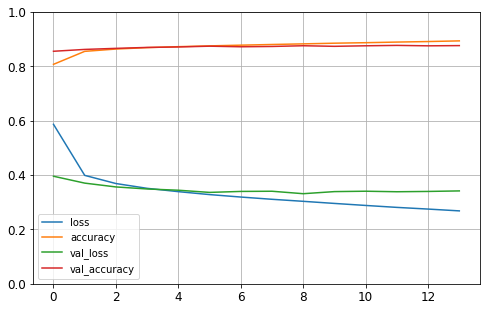

In [ ]:
pd.DataFrame(model_history2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# 김병민 - InceptionV3(GoogleNet)

In [ ]:
from functools import partial
from keras import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, Activation, Dropout, BatchNormalization

# GoogleNet 
# Inception v3에 해당. 재훈님 모델 그대로인 상태
tf.random.set_seed(42)
np.random.seed(42)

input_img = Input(shape=(28, 28, 1))

# Layer 1
layer1_tower_0 = Conv2D(16, (1, 1), padding='same', activation='relu')(input_img)

layer1_tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(input_img)
layer1_tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(layer1_tower_1)

layer1_tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(input_img)
layer1_tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(layer1_tower_2)

layer1_tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input_img)
layer1_tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(layer1_tower_3)

layer1_output = keras.layers.concatenate([layer1_tower_1, layer1_tower_2, layer1_tower_3, layer1_tower_0], axis=1)
layer1_output = BatchNormalization()(layer1_output)
layer1_output = MaxPooling2D((2,2))(layer1_output)

# Layer 2
layer2_tower_0 = Conv2D(16, (1, 1), padding='same', activation='relu')(layer1_output)

layer2_tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(layer1_output)
layer2_tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(layer2_tower_1)

layer2_tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(layer1_output)
layer2_tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(layer2_tower_2)

layer2_tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(layer1_output)
layer2_tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(layer2_tower_3)

layer2_output = keras.layers.concatenate([layer2_tower_1, layer2_tower_2, layer2_tower_3, layer2_tower_0], axis=1)
layer2_output = BatchNormalization()(layer2_output)
layer2_output = MaxPooling2D((2,2))(layer2_output)

# Flatten & Dense
layer2_output = Flatten()(layer2_output)
drop_layer = Dropout(0.4)(layer2_output)
dense1 = Dense(1024, activation = 'relu')(drop_layer)
dense2 = Dense(512, activation = 'relu')(dense1)
output = Dense(62,activation='softmax')(dense2)

inception_Model_datagen = Model(inputs=input_img,outputs=output)
inception_Model = Model(inputs=input_img,outputs=output)

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

# checkpoint
filepath="model_val_loss.best.hdf5"
checkpoint_acc = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
# Early Stopping
earlyStopping_acc = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=1, mode='auto', baseline=None, restore_best_weights=True)

callbacks_list = [checkpoint_acc, earlyStopping_acc]

# optimizer
SGD = keras.optimizers.SGD(momentum=0.9)
adam = keras.optimizers.Adam(learning_rate=1e-4, decay=1e-6)

inception_Model.compile(loss='categorical_crossentropy',optimizer=adam, metrics=['accuracy'])
history_inception = inception_Model.fit(X_train, y_train,
                                        batch_size=64,
                                        epochs=10,
                                        validation_data=(X_valid, y_valid),
                                        callbacks=callbacks_list)

Epoch 1/10
8725/8725 [==============================] - ETA: 0s - loss: 0.5479 - accuracy: 0.8163
Epoch 1: val_loss improved from inf to 0.42110, saving model to model_val_loss.best.hdf5
8725/8725 [==============================] - 121s 14ms/step - loss: 0.5479 - accuracy: 0.8163 - val_loss: 0.4211 - val_accuracy: 0.8511
Epoch 2/10
8725/8725 [==============================] - ETA: 0s - loss: 0.3986 - accuracy: 0.8549
Epoch 2: val_loss improved from 0.42110 to 0.38969, saving model to model_val_loss.best.hdf5
8725/8725 [==============================] - 118s 14ms/step - loss: 0.3986 - accuracy: 0.8549 - val_loss: 0.3897 - val_accuracy: 0.8564
Epoch 3/10
8724/8725 [============================>.] - ETA: 0s - loss: 0.3617 - accuracy: 0.8651
Epoch 3: val_loss improved from 0.38969 to 0.37206, saving model to model_val_loss.best.hdf5
8725/8725 [==============================] - 118s 13ms/step - loss: 0.3617 - accuracy: 0.8651 - val_loss: 0.3721 - val_accuracy: 0.8625
Epoch 4/10
8722/8725 [=

In [ ]:
inception_Model.save('byclass_vgg5.h5')

In [ ]:
score = inception_Model.evaluate(x_test, y_test)
print('\nTest acc: ', score)

3636/3636 [==============================] - 18s 5ms/step - loss: 0.3553 - accuracy: 0.8683

Test acc:  [0.35532644391059875, 0.8682536482810974]


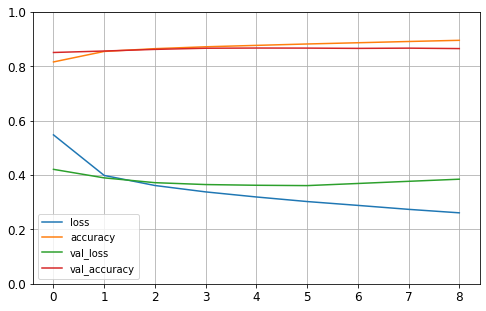

In [ ]:
pd.DataFrame(history_inception.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# DenseNet

In [ ]:
import keras
from keras.models import Model
from keras.layers import Input, GlobalAveragePooling2D, Dense, concatenate, AveragePooling2D
from keras.layers.convolutional import Conv2D
from keras.layers.core import Activation, Dropout
from keras.layers import BatchNormalization
import numpy as np

# DenseNet
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
class DenseNet:
    def __init__(self, input_shape=None, dense_blocks=3, dense_layers=-1, growth_rate=12, nb_classes=None,
                 dropout_rate=None, bottleneck=False, compression=1.0, weight_decay=1e-4, depth=40):

        # Checks
        if nb_classes == None:
            raise Exception(
                'Please define number of classes (e.g. num_classes=10). This is required for final softmax.')

        if compression <= 0.0 or compression > 1.0:
            raise Exception('Compression have to be a value between 0.0 and 1.0.')

        if type(dense_layers) is list:
            if len(dense_layers) != dense_blocks:
                raise AssertionError('Number of dense blocks have to be same length to specified layers')
        elif dense_layers == -1:
            dense_layers = int((depth - 4) / 3)
            if bottleneck:
                dense_layers = int(dense_layers / 2)
            dense_layers = [dense_layers for _ in range(dense_blocks)]
        else:
            dense_layers = [dense_layers for _ in range(dense_blocks)]

        self.dense_blocks = dense_blocks
        self.dense_layers = dense_layers
        self.input_shape = input_shape
        self.growth_rate = growth_rate
        self.weight_decay = weight_decay
        self.dropout_rate = dropout_rate
        self.bottleneck = bottleneck
        self.compression = compression
        self.nb_classes = nb_classes
        
    def build_model(self):
        img_input = Input(shape=self.input_shape, name='img_input')
        nb_channels = self.growth_rate
        
        x = Conv2D(2*self.growth_rate, (3,3), 
                   padding='same', strides = (1,1), 
                   kernel_regularizer=keras.regularizers.l2(self.weight_decay))(img_input)
        
        for block in range(self.dense_blocks-1):
            x, nb_channels = self.dense_block(x, self.dense_layers[block], nb_channels, self.growth_rate,
                                              self.dropout_rate, self.bottleneck, self.weight_decay)
            
            x = self.transition_layer(x, nb_channels, self.dropout_rate, self.compression, self.weight_decay)
            nb_channels = int(nb_channels*self.compression)
            
        x, nb_channels = self.dense_block(x, self.dense_layers[-1], nb_channels, self.growth_rate, self.dropout_rate, self.weight_decay)
        
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = GlobalAveragePooling2D()(x)
        prediction = Dense(self.nb_classes, activation='softmax')(x)
        
        return Model(inputs=img_input, outputs=prediction, name='densenet')
        
    def dense_block(self, x, nb_layers, nb_channels, growth_rate, dropout_rate=None, bottleneck=False, weight_decay=1e-4):
        for i in range(nb_layers):
            cb = self.convolution_block(x, growth_rate, dropout_rate, bottleneck)
            nb_channels += growth_rate
            x = concatenate([cb,x])
            
        return x, nb_channels
    
    def convolution_block(self, x, nb_channels, dropout_rate=None, bottleneck=False, weight_decay=1e-4):       

        # Bottleneck
        if bottleneck:
            bottleneckWidth = 4
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            x = Conv2D(nb_channels * bottleneckWidth, (1, 1),
                                     kernel_regularizer=keras.regularizers.l2(weight_decay))(x)
            # Dropout
            if dropout_rate:
                x = Dropout(dropout_rate)(x)

        # Standard (BN-ReLU-Conv)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(nb_channels, (3, 3), padding='same')(x)

        # Dropout
        if dropout_rate:
            x = Dropout(dropout_rate)(x)

        return x

    def transition_layer(self, x, nb_channels, dropout_rate=None, compression=1.0, weight_decay=1e-4):
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(int(nb_channels * compression), (1, 1), padding='same',
                                 kernel_regularizer=keras.regularizers.l2(weight_decay))(x)

        # Adding dropout
        if dropout_rate:
            x = Dropout(dropout_rate)(x)

        x = AveragePooling2D((2, 2), strides=(2, 2))(x)
        return x

In [ ]:
densenet = DenseNet((28,28,1), nb_classes=62, depth=25)

In [ ]:
model = densenet.build_model()

In [ ]:
model.summary()

Model: "densenet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img_input (InputLayer)         [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_20 (Conv2D)             (None, 28, 28, 24)   240         ['img_input[0][0]']              
                                                                                                  
 batch_normalization_10 (BatchN  (None, 28, 28, 24)  96          ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_8 (Activation)      (None, 28, 28, 24)   0           ['batch_normalization_10[0

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

# checkpoint
filepath="model_val_loss.best.hdf5"
checkpoint_acc = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='auto')
# Early Stopping
earlyStopping_acc = EarlyStopping(monitor='acc', min_delta=0.01, patience=3, verbose=1, mode='auto', baseline=None, restore_best_weights=True)

callbacks_list = [checkpoint_acc, earlyStopping_acc]

In [ ]:
# model_optimizer = Adam(lr=1E-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model_optimizer = tf.keras.optimizers.Adam()

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=model_optimizer, metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, 
                    batch_size=64, epochs=10
                    , validation_data=(X_valid, y_valid)
                    ,callbacks=callbacks_list)
score = model.evaluate(x_test, y_test)
print('\nTest Accuracy:', score)

Epoch 1/10
8725/8725 [==============================] - 287s 32ms/step - loss: 0.5470 - accuracy: 0.8320 - val_loss: 0.4516 - val_accuracy: 0.8515
Epoch 2/10
8725/8725 [==============================] - 281s 32ms/step - loss: 0.4148 - accuracy: 0.8586 - val_loss: 0.4177 - val_accuracy: 0.8539
Epoch 3/10
8725/8725 [==============================] - 280s 32ms/step - loss: 0.3900 - accuracy: 0.8648 - val_loss: 0.3992 - val_accuracy: 0.8637
Epoch 4/10
8725/8725 [==============================] - 280s 32ms/step - loss: 0.3766 - accuracy: 0.8679 - val_loss: 0.4023 - val_accuracy: 0.8575
Epoch 5/10
8725/8725 [==============================] - 281s 32ms/step - loss: 0.3669 - accuracy: 0.8704 - val_loss: 0.3907 - val_accuracy: 0.8634
Epoch 6/10
8725/8725 [==============================] - 280s 32ms/step - loss: 0.3597 - accuracy: 0.8723 - val_loss: 0.3789 - val_accuracy: 0.8665
Epoch 7/10
8725/8725 [==============================] - 281s 32ms/step - loss: 0.3545 - accuracy: 0.8734 - val_loss: 0

# 한다경 - VGG 5응용

In [18]:
# VGG-5 add Batch Nomalization(FC layer)
from functools import partial
tf.random.set_seed(42)
np.random.seed(42)

DefaultConv2D_G = partial(keras.layers.Conv2D, kernel_size=3, activation='relu', padding="SAME")

model4 = keras.models.Sequential([
    DefaultConv2D_G(filters=32, input_shape=[28, 28, 1]),
    DefaultConv2D_G(filters=32),
    keras.layers.MaxPooling2D(pool_size=2, strides=2),
    DefaultConv2D_G(filters=64),
    DefaultConv2D_G(filters=64),
    keras.layers.MaxPooling2D(pool_size=2, strides=2),
    DefaultConv2D_G(filters=128),
    DefaultConv2D_G(filters=128),
    keras.layers.MaxPooling2D(pool_size=2, strides=2),

    keras.layers.Flatten(),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=62, activation='softmax')
])

model4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                  

In [19]:
# Compile, train and evaluate
model4.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model4.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_valid, y_valid))



Epoch 1/10
8725/8725 [==============================] - 70s 7ms/step - loss: 0.5663 - accuracy: 0.8173 - val_loss: 0.3910 - val_accuracy: 0.8577
Epoch 2/10
8725/8725 [==============================] - 58s 7ms/step - loss: 0.4257 - accuracy: 0.8507 - val_loss: 0.3733 - val_accuracy: 0.8646
Epoch 3/10
8725/8725 [==============================] - 59s 7ms/step - loss: 0.3996 - accuracy: 0.8580 - val_loss: 0.3608 - val_accuracy: 0.8677
Epoch 4/10
8725/8725 [==============================] - 58s 7ms/step - loss: 0.3835 - accuracy: 0.8632 - val_loss: 0.3546 - val_accuracy: 0.8695
Epoch 5/10
8725/8725 [==============================] - 58s 7ms/step - loss: 0.3727 - accuracy: 0.8662 - val_loss: 0.3506 - val_accuracy: 0.8717
Epoch 6/10
8725/8725 [==============================] - 58s 7ms/step - loss: 0.3634 - accuracy: 0.8683 - val_loss: 0.3438 - val_accuracy: 0.8720
Epoch 7/10
8725/8725 [==============================] - 58s 7ms/step - loss: 0.3562 - accuracy: 0.8703 - val_loss: 0.3430 - val_ac

In [20]:
print("\n")
score = model4.evaluate(x_test, y_test)
print('\nTest Accuracy:', score)



3636/3636 [==============================] - 11s 3ms/step - loss: 0.3393 - accuracy: 0.8748

Test Accuracy: [0.3392772376537323, 0.8748388290405273]


In [23]:
# 선택모델 최적화
# VGG-5 add Batch Nomalization(all layer)
tf.random.set_seed(42)
np.random.seed(42)

from functools import partial


DefaultConv2D_G = partial(keras.layers.Conv2D, kernel_size=3, activation='relu', padding="SAME")

model5 = keras.models.Sequential([
    DefaultConv2D_G(filters=32, input_shape=[28, 28, 1]),
    keras.layers.BatchNormalization(),
    DefaultConv2D_G(filters=32),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=2, strides=2),
    DefaultConv2D_G(filters=64),
    keras.layers.BatchNormalization(),
    DefaultConv2D_G(filters=64),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=2, strides=2),
    DefaultConv2D_G(filters=128),
    keras.layers.BatchNormalization(),
    DefaultConv2D_G(filters=128),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=2, strides=2),

    keras.layers.Flatten(),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=62, activation='softmax')
])

model5.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_2 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_3 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                      

In [25]:
# Compile, train and evaluate
model5.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model5.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_valid, y_valid))

print("\n")
score = model5.evaluate(x_test, y_test)
print('\nTest Accuracy:', score)

Epoch 1/10
8725/8725 [==============================] - 68s 8ms/step - loss: 0.5093 - accuracy: 0.8304 - val_loss: 0.3852 - val_accuracy: 0.8602
Epoch 2/10
8725/8725 [==============================] - 66s 8ms/step - loss: 0.4130 - accuracy: 0.8546 - val_loss: 0.3586 - val_accuracy: 0.8676
Epoch 3/10
8725/8725 [==============================] - 66s 8ms/step - loss: 0.3870 - accuracy: 0.8622 - val_loss: 0.3525 - val_accuracy: 0.8698
Epoch 4/10
8725/8725 [==============================] - 66s 8ms/step - loss: 0.3718 - accuracy: 0.8668 - val_loss: 0.3436 - val_accuracy: 0.8731
Epoch 5/10
8725/8725 [==============================] - 66s 8ms/step - loss: 0.3607 - accuracy: 0.8695 - val_loss: 0.3410 - val_accuracy: 0.8739
Epoch 6/10
8725/8725 [==============================] - 66s 8ms/step - loss: 0.3516 - accuracy: 0.8718 - val_loss: 0.3432 - val_accuracy: 0.8730
Epoch 7/10
8725/8725 [==============================] - 66s 8ms/step - loss: 0.3447 - accuracy: 0.8733 - val_loss: 0.3399 - val_ac

In [26]:
#망의 크기 늘리기-각 layer의 unit 수 늘리기

# VGG-5 add Batch Nomalization(all layer)
tf.random.set_seed(42)
np.random.seed(42)

from functools import partial


DefaultConv2D_G = partial(keras.layers.Conv2D, kernel_size=3, activation='relu', padding="SAME")

model6 = keras.models.Sequential([
    DefaultConv2D_G(filters=64, input_shape=[28, 28, 1]),
    keras.layers.BatchNormalization(),
    DefaultConv2D_G(filters=64),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=2, strides=2),
    DefaultConv2D_G(filters=128),
    keras.layers.BatchNormalization(),
    DefaultConv2D_G(filters=128),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=2, strides=2),
    DefaultConv2D_G(filters=256),
    keras.layers.BatchNormalization(),
    DefaultConv2D_G(filters=256),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=2, strides=2),

    keras.layers.Flatten(),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=62, activation='softmax')
])

model6.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 64)        640       
                                                                 
 batch_normalization_10 (Bat  (None, 28, 28, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 batch_normalization_11 (Bat  (None, 28, 28, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                      

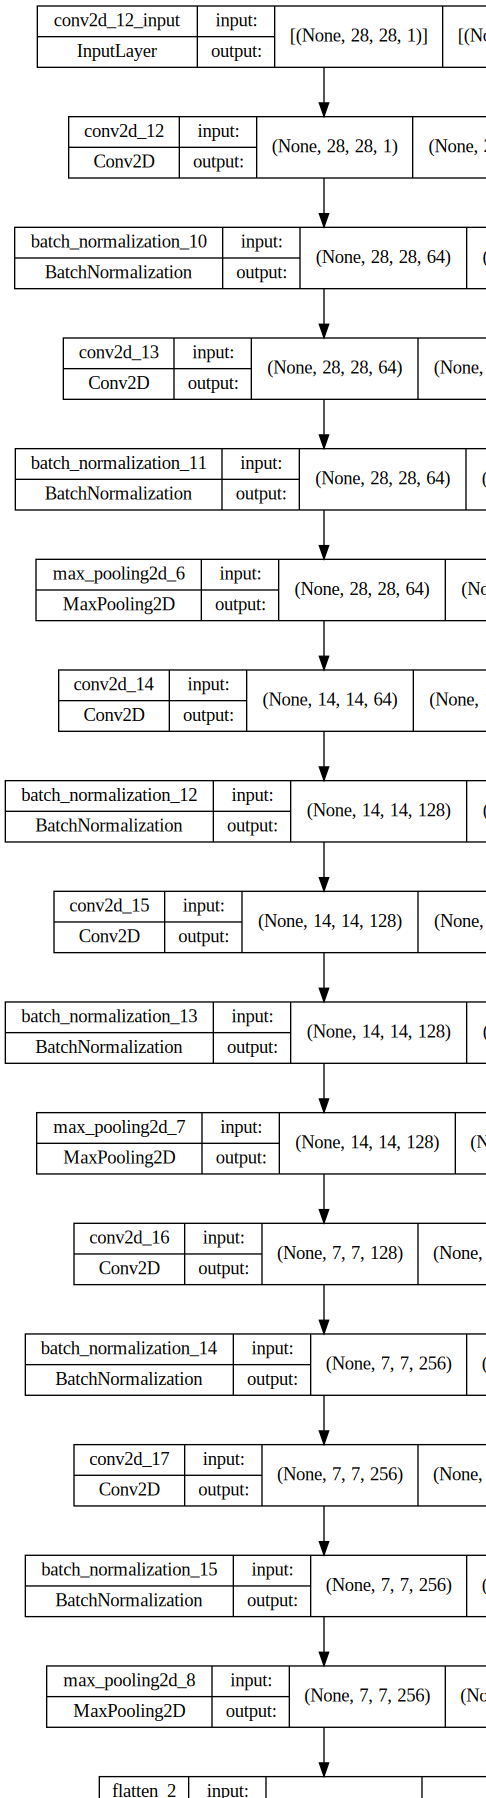

In [27]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
%matplotlib inline

SVG(model_to_dot(model6, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
# Compile, train and evaluate
model6.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model6.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_valid, y_valid))

print("\n")
score = model6.evaluate(x_test, y_test)
print('\nTest Accuracy:', score)

In [28]:
#망의 크기 늘리기-각 layer의 unit 수 늘리기

# VGG-5 add Batch Nomalization(all layer)
tf.random.set_seed(42)
np.random.seed(42)

from functools import partial


DefaultConv2D_G = partial(keras.layers.Conv2D, kernel_size=3, activation='relu', padding="SAME")

model7 = keras.models.Sequential([
    DefaultConv2D_G(filters=64, input_shape=[28, 28, 1]),
    keras.layers.BatchNormalization(),
    DefaultConv2D_G(filters=64),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=2, strides=2),
    DefaultConv2D_G(filters=128),
    keras.layers.BatchNormalization(),
    DefaultConv2D_G(filters=128),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=2, strides=2),
    DefaultConv2D_G(filters=256),
    keras.layers.BatchNormalization(),
    DefaultConv2D_G(filters=256),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=2, strides=2),

    keras.layers.Flatten(),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=62, activation='softmax')
])

model7.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 28, 28, 64)        640       
                                                                 
 batch_normalization_18 (Bat  (None, 28, 28, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_19 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 batch_normalization_19 (Bat  (None, 28, 28, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                      

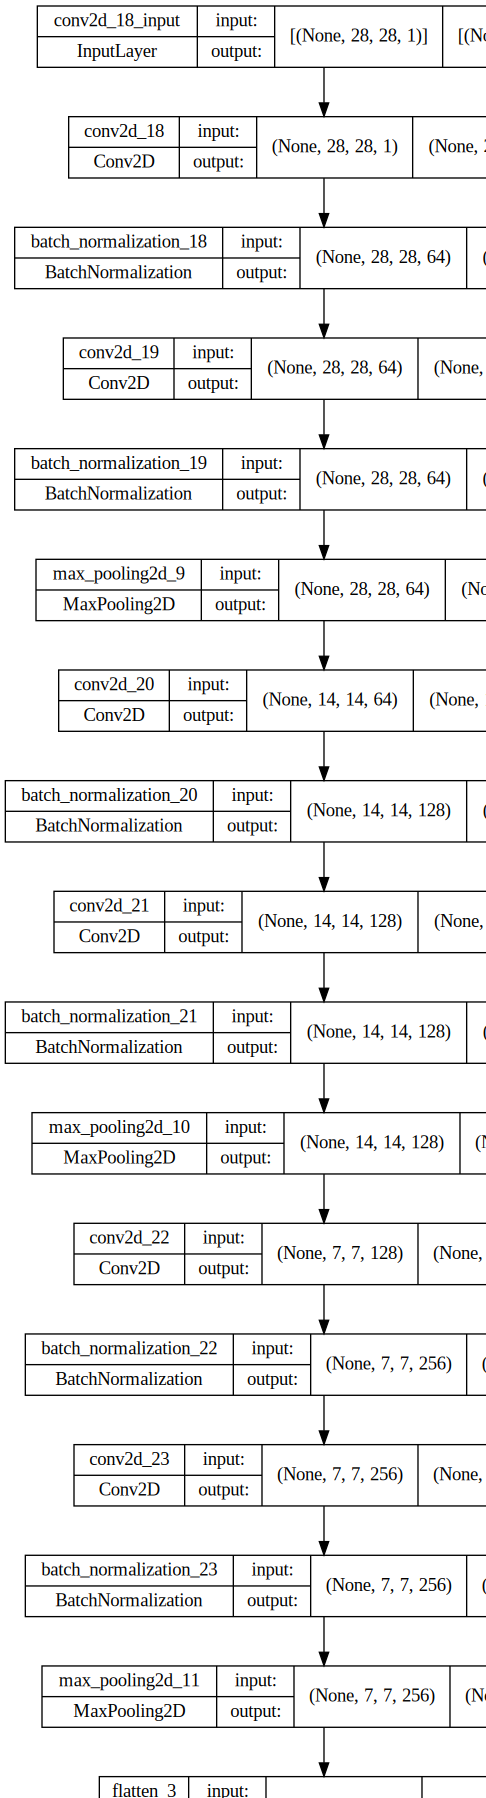

In [29]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
%matplotlib inline

SVG(model_to_dot(model7, show_shapes=True).create(prog='dot', format='svg'))

In [30]:
# Compile, train and evaluate
model7.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model7.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_valid, y_valid))

print("\n")
score = model7.evaluate(x_test, y_test)
print('\nTest Accuracy:', score)

Epoch 1/10
8725/8725 [==============================] - 102s 12ms/step - loss: 0.4992 - accuracy: 0.8314 - val_loss: 0.3782 - val_accuracy: 0.8610
Epoch 2/10
8725/8725 [==============================] - 99s 11ms/step - loss: 0.3932 - accuracy: 0.8589 - val_loss: 0.3535 - val_accuracy: 0.8692
Epoch 3/10
8725/8725 [==============================] - 99s 11ms/step - loss: 0.3655 - accuracy: 0.8668 - val_loss: 0.3400 - val_accuracy: 0.8723
Epoch 4/10
8725/8725 [==============================] - 99s 11ms/step - loss: 0.3494 - accuracy: 0.8713 - val_loss: 0.3339 - val_accuracy: 0.8754
Epoch 5/10
8725/8725 [==============================] - 99s 11ms/step - loss: 0.3367 - accuracy: 0.8753 - val_loss: 0.3342 - val_accuracy: 0.8761
Epoch 6/10
8725/8725 [==============================] - 99s 11ms/step - loss: 0.3252 - accuracy: 0.8789 - val_loss: 0.3275 - val_accuracy: 0.8775
Epoch 7/10
8725/8725 [==============================] - 100s 11ms/step - loss: 0.3151 - accuracy: 0.8813 - val_loss: 0.3303

In [31]:
# Early stopping
#망의 크기 늘리기-각 layer의 unit 수 늘리기

# VGG-5 add Batch Nomalization(all layer)
tf.random.set_seed(42)
np.random.seed(42)

from functools import partial


DefaultConv2D_G = partial(keras.layers.Conv2D, kernel_size=3, activation='relu', padding="SAME")

model8 = keras.models.Sequential([
    DefaultConv2D_G(filters=64, input_shape=[28, 28, 1]),
    keras.layers.BatchNormalization(),
    DefaultConv2D_G(filters=64),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=2, strides=2),
    DefaultConv2D_G(filters=128),
    keras.layers.BatchNormalization(),
    DefaultConv2D_G(filters=128),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=2, strides=2),
    DefaultConv2D_G(filters=256),
    keras.layers.BatchNormalization(),
    DefaultConv2D_G(filters=256),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=2, strides=2),

    keras.layers.Flatten(),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=62, activation='softmax')
])

model8.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 28, 28, 64)        640       
                                                                 
 batch_normalization_26 (Bat  (None, 28, 28, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_27 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 batch_normalization_27 (Bat  (None, 28, 28, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                      

In [32]:
# Compile
model8.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [33]:
# Set callback functions to stop training early and save the best model so far
keras_callbacks= [
    callbacks.EarlyStopping(monitor = 'val_loss', patience =3,
                            mode = 'auto', verbose = 1),
    callbacks.ModelCheckpoint(filepath = 'best_model_vgg.h5', monitor = 'val_loss',
                              save_best_only = True, mode = 'auto', verbose = 1)
]

# train
model8_history = model8.fit(X_train, y_train, epochs=50, batch_size=64,callbacks=keras_callbacks, validation_data=(X_valid, y_valid))

Epoch 1/50
8725/8725 [==============================] - ETA: 0s - loss: 0.5000 - accuracy: 0.8315
Epoch 1: val_loss improved from inf to 0.38508, saving model to best_model_vgg.h5
8725/8725 [==============================] - 103s 12ms/step - loss: 0.5000 - accuracy: 0.8315 - val_loss: 0.3851 - val_accuracy: 0.8599
Epoch 2/50
8724/8725 [============================>.] - ETA: 0s - loss: 0.3932 - accuracy: 0.8586
Epoch 2: val_loss improved from 0.38508 to 0.35982, saving model to best_model_vgg.h5
8725/8725 [==============================] - 100s 11ms/step - loss: 0.3931 - accuracy: 0.8586 - val_loss: 0.3598 - val_accuracy: 0.8661
Epoch 3/50
8724/8725 [============================>.] - ETA: 0s - loss: 0.3664 - accuracy: 0.8665
Epoch 3: val_loss improved from 0.35982 to 0.33929, saving model to best_model_vgg.h5
8725/8725 [==============================] - 102s 12ms/step - loss: 0.3664 - accuracy: 0.8665 - val_loss: 0.3393 - val_accuracy: 0.8732
Epoch 4/50
8721/8725 [======================

In [34]:
model8.save('select_model_vgg5.h5')

In [35]:
# Evaluate
score = model8.evaluate(x_test, y_test)
print('\nTest Accuracy:', score)

3636/3636 [==============================] - 13s 4ms/step - loss: 0.3328 - accuracy: 0.8778

Test Accuracy: [0.33282530307769775, 0.8778219223022461]


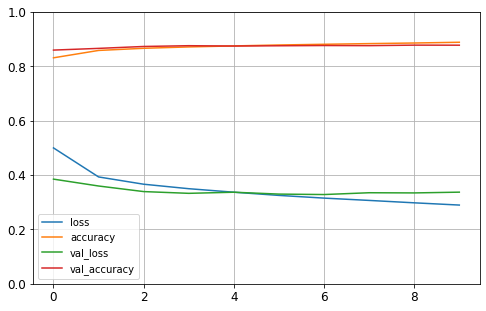

In [36]:
# Learnig curve
pd.DataFrame(model8_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()